# 8. Systematic uncertainties

In this exercise, we will analyse the data of PKS 2155-304 from the H.E.S.S. DL3-DR1, compute its average spectrum and compare two spectral hypotheses. Then, we will assess the systematic uncertainties on the spectrum by studying the effect of a bias on the energy scale.

For this tutorial, we will need a few extra python packages (such as `astroquery` to query Virtual Observatory services).

In [1]:
# !mamba install -c conda-forge astroquery corner tqdm
#
# or:
#
# !mamba create -n cads-2024 -c conda-forge gammapy=1.2 ipykernel astroquery corner tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

import corner
import numpy as np
import os

from IPython.display import display
from scipy.stats import chi2, norm
from tqdm import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from astroquery.simbad import Simbad

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.makers.utils import make_theta_squared_table
from gammapy.makers import (
    DatasetsMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
)
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True
from gammapy.visualization import plot_spectrum_datasets_off_regions, plot_theta_squared_table

from regions import CircleSkyRegion

/home/jlenain/local/opt/mambaforge/envs/cads-2024/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We first load the data for the H.E.S.S. DL3-DR1:

In [3]:
data_store = DataStore.from_dir(
    f"$GAMMAPY_DATA/hess-dl3-dr1"
)

In [4]:
display(data_store.obs_table)

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20301,228.6125,-58.771667,320.56754,-0.8857012,36.839905,53.160095,171.07347,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1534.0626,0.9115048,103764878.0,103766561.0,2004-04-15,23:35:42.184,2004-04-16,00:03:45.184,4,"1,2,3,4",0,1.1503073,11624,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20302,228.6125,-59.771667,320.04724,-1.7397733,36.11632,53.88368,177.10521,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.3478,0.9128108,103766698.0,103768380.0,2004-04-16,00:06:02.184,2004-04-16,00:34:04.184,4,"1,2,3,4",0,1.1493496,11794,MSH 15-52,msh1552,0.6156251,0.3801894,100.0


We set the properties of the source of interest. Bonus: we use Virtual Observatory services to query the source parameters.

In [5]:
src = dict()
src['Name'] = 'PKS 2155-304'
src['Position'] = SkyCoord.from_name(src['Name'])

try:
    simbad = Simbad()
    simbad.add_votable_fields("z_value")
    query = simbad.query_object(src['Name'])
    src['Redshift'] = query["Z_VALUE"].data[0]
except NameError:
    src['Redshift'] = 0.116

We select a sub-sample of H.E.S.S. data acquired on our source:

In [6]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=src['Position'].ra,
    lat=src['Position'].dec,
    radius="3 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)
obs_ids = selected_obs_table["OBS_ID"]
observations = data_store.get_observations(obs_ids)

Obs Id: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 725.75it/s]


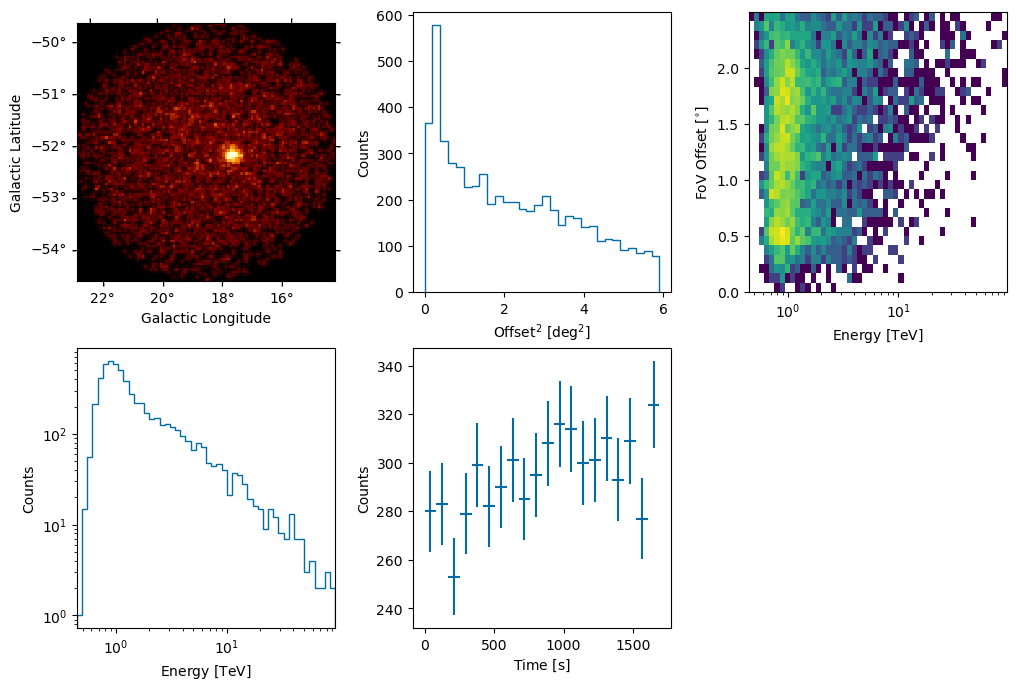

In [7]:
obs = data_store.obs(obs_ids[0])
obs.events.select_offset([0, 2.5] * u.deg).peek()

In [8]:
on_region_radius = Angle("0.1 deg")

on_region = CircleSkyRegion(center=src['Position'], radius=on_region_radius)
exclusion_region = CircleSkyRegion(center=src['Position'],radius=0.5 * u.deg)
geom = WcsGeom.create(
    npix=(120, 120), binsz=0.05, skydir=src['Position'], proj="TAN", frame="icrs"
)
exclusion_mask = ~geom.region_mask([exclusion_region])

# Data reduction

Let's perform a 1D analysis of the data.

In [9]:
energy_axis = MapAxis.from_energy_bounds(0.02, 200, nbin=5, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.005, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true")

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp"])

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [10]:
%%time

# Parallel version
makers = [dataset_maker, bkg_maker, safe_mask_maker]  # the order matters
datasets_maker = DatasetsMaker(makers, stack_datasets=False, n_jobs=8)
datasets = datasets_maker.run(dataset_empty, observations)

Data reduction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 58292.78it/s]


CPU times: user 1.35 s, sys: 103 ms, total: 1.46 s
Wall time: 3.8 s


In [11]:
%%time

# Non-parallel version

datasets = Datasets()

for obs in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=f"obs-{obs.obs_id}"), obs
    )
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

CPU times: user 11.9 s, sys: 70.9 ms, total: 12 s
Wall time: 12 s


/home/jlenain/local/opt/mambaforge/envs/cads-2024/lib/python3.12/site-packages/regions/shapes/circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


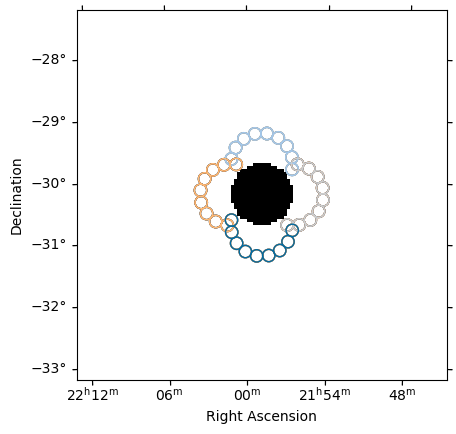

In [12]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [13]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,177,164.44444274902344,21.240110976278157,12.55555534362793,29.000000194460153,29.000000194460153,nan,5918441.0,874051840.0,1645.9436731394428,1689.000000000005,0.10753709430553808,0.007628180446588244,0.09990891270013215,20,12,wstat,465.48607229559343,113,12.0,108.0,0.1111111119389534
stacked,518,500.3333435058594,40.9992906983109,17.66666603088379,67.6999994883686,67.6999994883686,nan,6459387.0,1529238912.0,3242.0454647149895,3378.0000000000005,0.15977567422717737,0.005449234510484225,0.1543264426582753,20,12,wstat,1718.6130830794496,159,12.0,108.00000762939453,0.1111111044883728
stacked,1530,1503.3333740234375,75.4421582182852,26.66666603088379,176.9999963407963,176.9999963407963,nan,431920.1875,2047834368.0,4825.489054074511,5065.999999999999,0.31706630827565757,0.005526210034269415,0.3115401065419605,20,13,wstat,5815.392671674496,240,13.0,117.0,0.1111111119389534
stacked,3105,3060.0,108.96720948050593,45.0,351.00000068195163,351.00000068195163,nan,1844916.25,2465618944.0,6386.866192122923,6756.000000000001,0.48615391439223693,0.007045708904235318,0.47910820548800165,20,14,wstat,12015.967143564481,405,14.0,126.0,0.1111111119389534
stacked,4281,4225.0,128.83835263525495,56.0,478.5000013739616,478.5000013739616,nan,2765265.0,2825196032.0,7954.743777347735,8445.000000000005,0.5381694394973169,0.007039824483029607,0.5311296150142873,20,14,wstat,16743.716749418716,504,14.0,126.0,0.1111111119389534
stacked,5283,5216.0,143.40993462555284,67.00000762939453,588.6000040434301,588.6000040434301,nan,10584726.0,3139006208.0,9517.102900041273,10133.000000000004,0.5551059030765644,0.00703995830801661,0.5480659455701986,20,14,wstat,20723.857726273356,603,14.0,125.99998474121094,0.1111111268401146
stacked,5900,5822.888671875,151.2596691666661,77.11112213134766,659.400004518181,659.400004518181,nan,26133248.0,3429723136.0,11083.773701896891,11822.0,0.5323096770723735,0.006957118054309496,0.525352540432909,20,14,wstat,23037.9478749026,694,14.0,125.99998474121094,0.1111111268401146
stacked,7114,7011.77783203125,165.037168495285,102.22222137451172,803.4000054958461,803.4000054958461,nan,45821176.0,3707847680.0,12648.486569276083,13510.000000000004,0.5624388310045191,0.00808177490758582,0.5543570603192377,20,15,wstat,27478.54292530373,920,15.0,135.0,0.1111111119389534


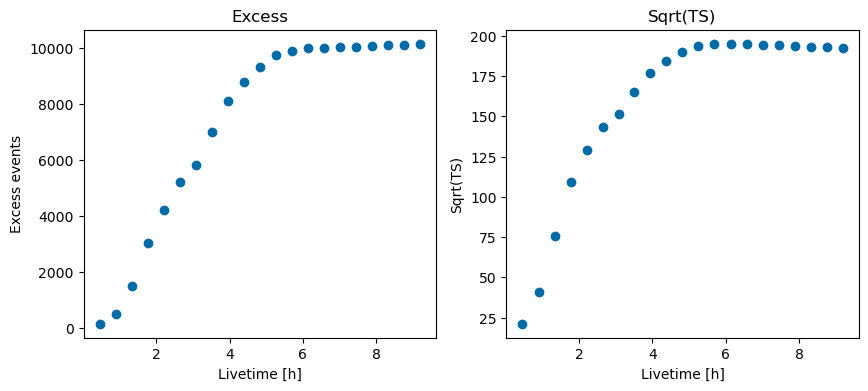

In [14]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

plt.show()

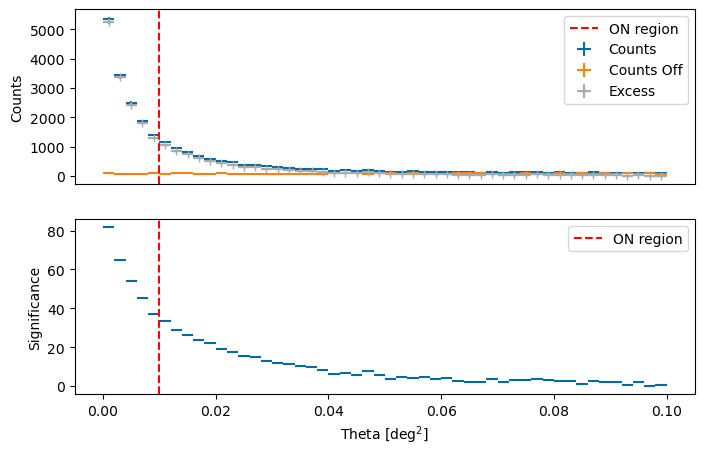

In [15]:
theta2_axis = MapAxis.from_bounds(0, 0.1, nbin=50, interp="lin", unit="deg2")

theta2_table = make_theta_squared_table(
    observations=observations,
    position=src['Position'],
    theta_squared_axis=theta2_axis,
)

on_region_radius = Angle("0.1 deg")

fig = plt.figure(figsize=(8, 5))
plot_theta_squared_table(theta2_table)
for ax in fig.get_axes():
    ax.axvline(on_region_radius.value**2, color="red", linestyle="--", label="ON region")
    ax.legend()
plt.show()

In [16]:
dataset_stack = datasets.stack_reduce(name="hess")

# Fit stacked spectrum

We will fit the overall spectrum of PKS 2155-304, under two hypotheses:
* a simple power-law
* a log-parabola

We will judge which hypotheses reperesent best the data by comparing the fit statistics.

In [17]:
reference_energy = 300. * u.Unit("GeV")

In [18]:
dataset_stack_pl = dataset_stack.copy(name="hess")

spectral_model_pl = PowerLawSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                          reference=reference_energy,
                                          index=2.
                                         )
spectral_model_pl.parameters["amplitude"].frozen = False
spectral_model_pl.parameters["amplitude"].min = 0.
spectral_model_pl.parameters["index"].frozen = False

source_pl = SkyModel(
    spectral_model=spectral_model_pl,
    name=src['Name'],
)

dataset_stack_pl.models = source_pl
print(dataset_stack_pl)

SpectrumDatasetOnOff
--------------------

  Name                            : hess 

  Total counts                    : 10395 
  Total background counts         : 232.89
  Total excess counts             : 10162.11

  Predicted counts                : 1036805.73
  Predicted background counts     : 210.05
  Predicted excess counts         : 1036595.68

  Exposure min                    : 8.52e+07 m2 s
  Exposure max                    : 9.43e+09 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1969796.57

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : PKS 2155-304
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index

In [19]:
%%time

fit_pl = Fit()
result_pl = fit_pl.run(datasets=dataset_stack_pl)

# we make a copy here to compare it later
model_best_pl = source_pl.copy(name=src['Name'])

CPU times: user 209 ms, sys: 4.05 ms, total: 213 ms
Wall time: 212 ms


In [20]:
dataset_stack_lp = dataset_stack.copy(name="hess")

spectral_model_lp = LogParabolaSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                             reference=reference_energy,
                                             alpha=2.,
                                             beta=0.01,
                                            )
spectral_model_lp.parameters["amplitude"].frozen = False
spectral_model_lp.parameters["amplitude"].min = 0.
spectral_model_lp.parameters["alpha"].frozen = False
spectral_model_lp.parameters["beta"].frozen = False
spectral_model_lp.parameters["beta"].min = 0.

source_lp = SkyModel(
    spectral_model=spectral_model_lp,
    name=src['Name'],
)

dataset_stack_lp.models = source_lp
print(dataset_stack_lp)

SpectrumDatasetOnOff
--------------------

  Name                            : hess 

  Total counts                    : 10395 
  Total background counts         : 232.89
  Total excess counts             : 10162.11

  Predicted counts                : 998654.64
  Predicted background counts     : 210.06
  Predicted excess counts         : 998444.59

  Exposure min                    : 8.52e+07 m2 s
  Exposure max                    : 9.43e+09 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1893644.41

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : PKS 2155-304
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      ampl

In [21]:
%%time

fit_lp = Fit()
result_lp = fit_lp.run(datasets=dataset_stack_lp)

# we make a copy here to compare it later
model_best_lp = source_lp.copy(name=src['Name'])

CPU times: user 481 ms, sys: 4.03 ms, total: 485 ms
Wall time: 483 ms


In [22]:
def sigma_lp_vs_pl(df=1):
    ts_pl = result_pl.total_stat
    ts_lp = result_lp.total_stat
    Delta_TS = ts_pl-ts_lp
    p_value = chi2.sf(Delta_TS, df=df)
    sigma = norm.isf(0.5*p_value)  # 0.5 only for 1-sided hypothesis on curvature parameter (which is constrained positive)
    return sigma

In [23]:
sigma_lp_pl = sigma_lp_vs_pl()

criterion_lp_pl_selection = 3.0  # How many sigma to prefer LP over PL ?

if sigma_lp_pl >= criterion_lp_pl_selection:
    print(f"Log-parabola preferred over a power-law at {sigma_lp_pl:.2f} sigmas.")
    result = result_lp
    fit = fit_lp
    dataset_stack = dataset_stack_lp.copy(name="hess")
    model_best = source_lp.copy(name=src['Name'])
else:
    print(f"Log-parabola *not* preferred over a power-law (Delta TS(log-parabola vs power-law)={sigma_lp_pl:.2f} sigmas).")
    result = result_pl
    fit = fit_pl
    dataset_stack = dataset_stack_pl.copy(name="hess")
    model_best = source_pl.copy(name=src['Name'])
    
source_model = SkyModel(
    spectral_model=model_best.spectral_model,
    name=src['Name'],
)
dataset_stack.models = source_model

Log-parabola preferred over a power-law at 8.57 sigmas.


# Compute flux points

In [24]:
n_jobs = 8
energy_edges = resample_energy_edges(dataset_stack, conditions={'sqrt_ts_min': 2.})

fpe = FluxPointsEstimator(
    energy_edges=energy_edges,
    source=src['Name'],
    selection_optional=["errn-errp", "ul", "scan"],
    fit=fit,
    n_jobs=n_jobs,
)
flux_points = fpe.run([dataset_stack])

Energy bins: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 61.53it/s]
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Scan values: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

# Spectral energy distribution

We will produce an SED with the best-fit model and results.

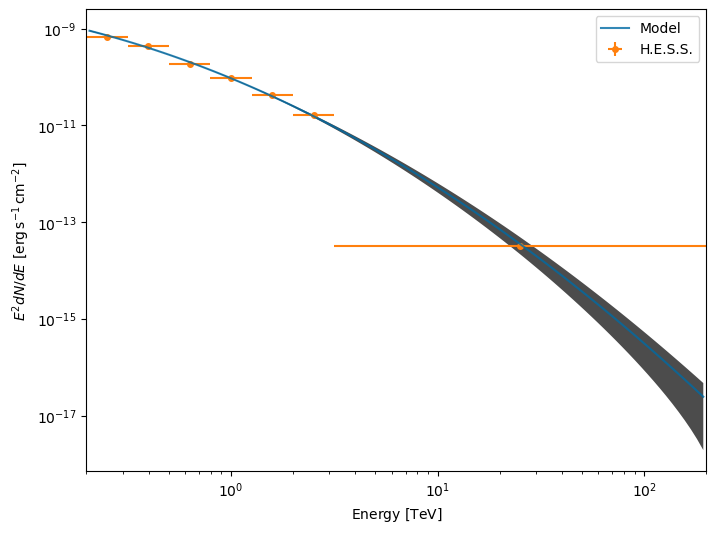

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [energy_edges[0], energy_edges[-1]],
    "sed_type": "e2dnde",  # "dnde"
    "yunits": u.Unit("erg cm-2 s-1"),  # u.Unit("cm-2 s-1 TeV-1")
    "ax": ax,
}

spec = dataset_stack.models[src['Name']].spectral_model

# plot best-fit model
spec.plot(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    label="Model",
    alpha=0.8,
    zorder=3,
)
spec.plot_error(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    alpha=0.7,
    zorder=2,
)

flux_points.plot(ax=plot_kwargs['ax'],
             sed_type=plot_kwargs['sed_type'],
             label="H.E.S.S.")

ylabel = ax.get_ylabel()
ax.set_ylabel(ylabel.replace('e2dnde', '$E^2 dN/dE$'))
ax.legend()
plt.show()

# Systematics study

Now, we will define a custom spectral model by introducing a nuisance parameter on the energy scale, and study the systematic effet of a bias on this parameter.

In [26]:
# Define some custom biased spectral models
#
# See https://github.com/bkhelifi/CTAO-CTAC_Meeting_Granada_2023/blob/main/Crab_simulations_systematic_errors_Solution.ipynb

class BiasedPowerLawSpectralModel(SpectralModel):
    tag = "BiasedPowerLawSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    index = Parameter("index", 2.5, min=0)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1., min=0.)
        
    @staticmethod
    def evaluate(energy, amplitude, index, reference, bias):
        energy = bias.value * energy
        pwl = PowerLawSpectralModel.evaluate(
            energy=energy,
            index=index,
            amplitude=amplitude,
            reference=reference,
        )
        return pwl

class BiasedLogParabolaSpectralModel(SpectralModel):
    tag = "BiasedLogParabolaSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    alpha = Parameter("alpha", 2.5, min=0)
    beta = Parameter("beta", 0.5)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1., min=0.)
        
    @staticmethod
    def evaluate(energy, amplitude, alpha, beta, reference, bias):
        energy = bias.value * energy
        logpwl = LogParabolaSpectralModel.evaluate(
            energy=energy,
            alpha=alpha,
            beta=beta,
            amplitude=amplitude,
            reference=reference,
        )
        return logpwl

In [27]:
# Define the biased model, based on the best model shape obtained above (PL or LP)

if sigma_lp_pl >= criterion_lp_pl_selection:
    spectral_model_biased = BiasedLogParabolaSpectralModel(
        amplitude=model_best.spectral_model.amplitude,
        reference=model_best.spectral_model.reference,
        alpha=model_best.spectral_model.alpha,
        beta=model_best.spectral_model.beta,
    )
    spectral_model_biased.parameters["alpha"].frozen = False
    spectral_model_biased.parameters["beta"].frozen = False
    spectral_model_biased.parameters["beta"].min = 0.
else:
    spectral_model_biased = BiasedPowerLawSpectralModel(
        amplitude=model_best.spectral_model.amplitude,
        reference=model_best.spectral_model.reference,
        index=model_best.spectral_model.index,
    )
    spectral_model_biased.parameters["index"].frozen = False

spectral_model_biased.parameters["amplitude"].frozen = False
spectral_model_biased.parameters["amplitude"].min = 0.

biased_model = SkyModel(
    spectral_model=spectral_model_biased,
    name=f"biased_{src['Name']}",
)
print(biased_model)

SkyModel

  Name                      : biased_PKS 2155-304
  Datasets names            : None
  Spectral model type       : BiasedLogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   4.05e-09   +/- 5.8e-11 1 / (TeV s cm2)
    alpha                         :      3.260   +/-    0.04             
    beta                          :      0.211   +/-    0.03             
    reference             (frozen):    300.000       GeV         
    bias                          :      1.000   +/-    0.00             




In [28]:
%%time

# Definition of reference dataset
reference_dataset = dataset_stack.copy(name="hess")

# Fake counts taking bias into account
simulated_biased_datasets = []
n_sim = 1000
energy_bias = 10./100.

# Fit the unbiased model
results_biased = []
fit_biased = Fit()

for i in tqdm(range(n_sim)):
    ds = reference_dataset
    # Randomize random bias
    biased_model.spectral_model.bias.value = np.random.normal(loc=1.0, scale=energy_bias)
    biased_model.spectral_model.bias.frozen = True
    
    # Set the model on the ON-OFF dataset using the *biased* model
    ds.models = [biased_model]

    ds.fake(random_state='random-seed', npred_background=reference_dataset.background)
    
    # We use a copy of the best (PL or LP) *unbiased* model
    ds.models = [source_model.copy(name=src['Name'])]
    
    fit_result = fit_biased.run([ds])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results_biased.append(par_dict)
        
    simulated_biased_datasets.append(ds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.51it/s]


In [29]:
fitted_params_with_energy_bias = Table(results_biased).to_pandas()
biased_mean = fitted_params_with_energy_bias.mean()
biased_uncertainty = fitted_params_with_energy_bias.std()

In [30]:
for par in result.models[src['Name']].spectral_model.parameters.free_parameters:
    statistic_uncertainty = par.error * par.unit
    total_uncertainty = biased_uncertainty[par.name] * par.unit
    systematic_uncertainty = np.sqrt(np.abs(total_uncertainty**2 - statistic_uncertainty**2))
    print(f"{par.name} : {par.quantity.value:.3e} +/-\t"
          f" {statistic_uncertainty.value:.3e} (stat.) +/-\t"
          f" {systematic_uncertainty.value:.3e} (syst.) {par.quantity.unit}")

amplitude : 4.046e-09 +/-	 5.758e-11 (stat.) +/-	 1.588e-09 (syst.) 1 / (TeV s cm2)
alpha : 3.260e+00 +/-	 4.364e-02 (stat.) +/-	 4.479e-02 (syst.) 
beta : 2.113e-01 +/-	 2.771e-02 (stat.) +/-	 6.566e-03 (syst.) 


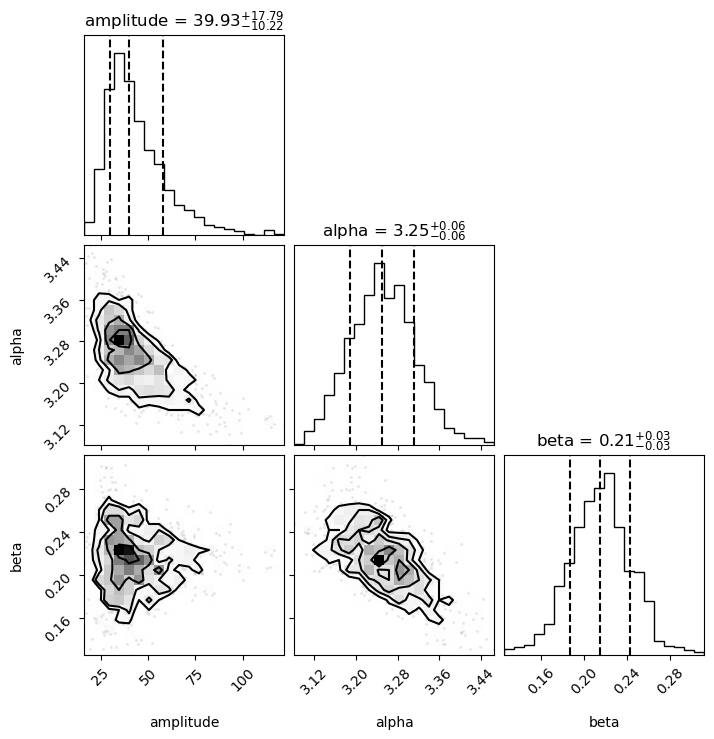

In [31]:
fitted_params_with_energy_bias['amplitude'] *= 1e10

figure = corner.corner(fitted_params_with_energy_bias,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
                       title_kwargs={"fontsize": 12})

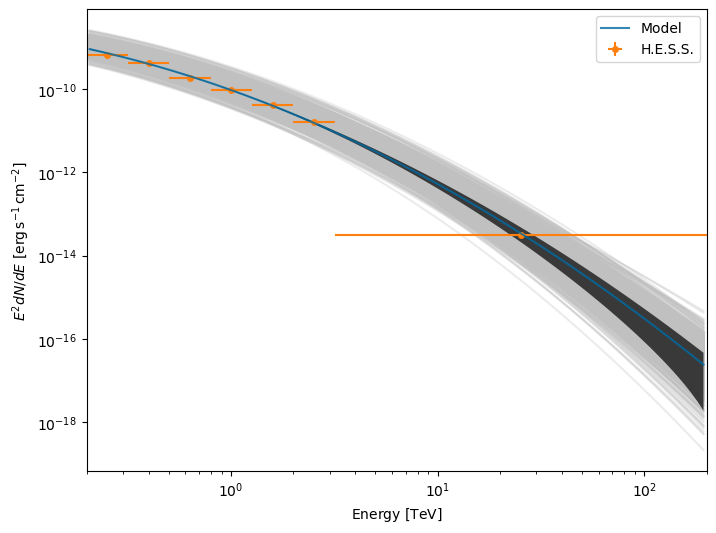

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [energy_edges[0], energy_edges[-1]],
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "ax": ax,
}

spec = dataset_stack.models[src['Name']].spectral_model

# plot best-fit model
spec.plot(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    label="Model",
    alpha=0.8,
    zorder=3,
)
spec.plot_error(
    ax=plot_kwargs['ax'],
    energy_bounds=plot_kwargs['energy_bounds'],
    sed_type=plot_kwargs['sed_type'],
    alpha=0.7,
    zorder=2,
)

for i, result_biased in enumerate(results_biased):
    if sigma_lp_pl >= criterion_lp_pl_selection:
        spec_biased = LogParabolaSpectralModel(
            amplitude=result_biased["amplitude"],
            reference=reference_energy,
            alpha=result_biased["alpha"],
            beta=result_biased["beta"],
        )
    else:
        spec_biased = PowerLawSpectralModel(
            amplitude=result_biased["amplitude"],
            reference=reference_energy,
            index=result_biased["index"],
        )

    spec_biased.plot(
        ax=plot_kwargs['ax'],
        energy_bounds=plot_kwargs['energy_bounds'],
        sed_type=plot_kwargs['sed_type'],
        # label="Biased model",
        alpha=0.3,
        color='silver',
        zorder=1,
    )

flux_points.plot(ax=plot_kwargs['ax'],
             sed_type=plot_kwargs['sed_type'],
             label="H.E.S.S.")

ylabel = ax.get_ylabel()
ax.set_ylabel(ylabel.replace('e2dnde', '$E^2 dN/dE$'))
ax.legend()
plt.show()

Scan values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 337.93it/s]


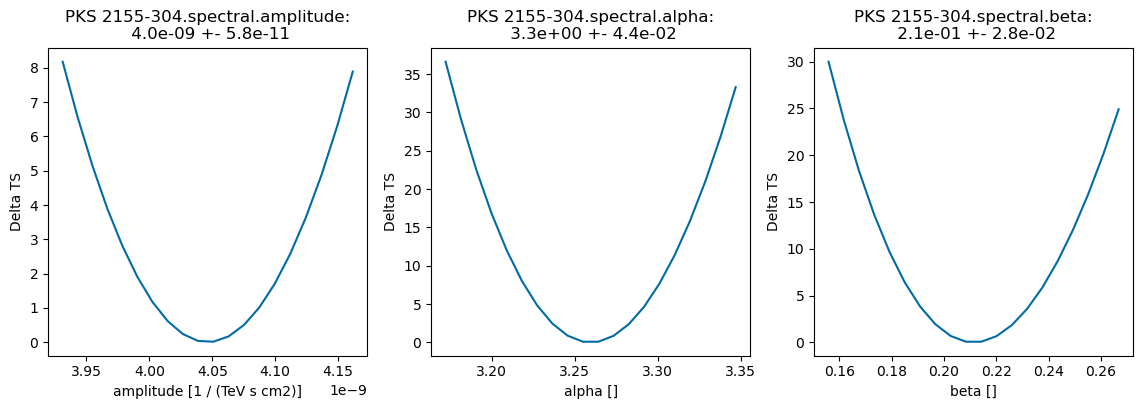

In [33]:
# Likelihood profiles

total_stat = result.total_stat

ds = Datasets([dataset_stack])

fig, axes = plt.subplots(nrows=1, ncols=len(ds.parameters.free_parameters), figsize=(14, 4))

for ax, par in zip(axes, ds.parameters.free_parameters):
    par.scan_n_values = 20
    idx = ds.parameters.index(par)
    name = ds.models.parameters_unique_names[idx]
    profile = fit.stat_profile(datasets=ds, parameter=par)
    ax.plot(profile[f"{name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.name} [{par.unit}]")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{name}:\n {par.value:.1e} +- {par.error:.1e}")
plt.show()

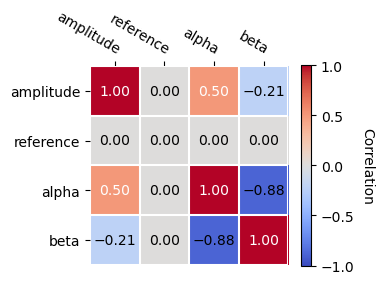

In [34]:
# Parameters correlations

result.models.covariance.plot_correlation()
plt.show()